In [2]:
import numpy as np
import matplotlib.pyplot as plt
import starry

import exoplanet as exo


In [3]:
starry.__version__

'1.0.0.dev3'

In [4]:
map = starry.Map(ydeg=20, udeg=2, rv=True, lazy=False)


In [19]:
time, vels, verr = np.loadtxt('../data/vst222259.ascii', usecols=[1,2,3], unpack=True)
ha = np.loadtxt('../data/222259_mbcvel.ascii', usecols=[-1])

time = time[:-4]
vels = vels[:-4]
verr = verr[:-4]
ha   = ha[:-7]

time -= 18706.5

In [20]:
Prot = 2.85             # days
P = 8.1387              # days
t0 = 0.168
e = 0.0                   
w = 0.0
inc = 90.0


vsini = 18.3 * 1e3      # m /s
r = 0.06472             # In units of Rstar
b = -0.40               # I want it to transit in the South!
a = 19.42               # In units of Rstar
u1 = 0.95
u2 = 0.20
obl = -0
gamma = -15
gammadot = 100
gammadotdot = 800

veq = vsini / np.sin(inc * np.pi / 180.0)


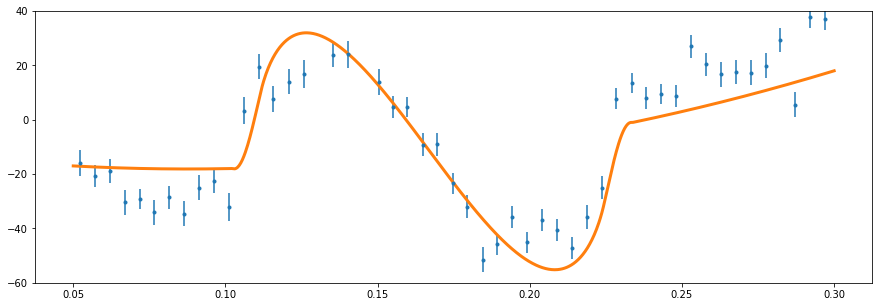

In [21]:
map.reset()
map.inc = inc
map.obl = obl
#map.add_spot(spot_amp, sigma=spot_sig, lon=spot_lon, lat=-spot_lat)
map[1:] = [u1, u2]
map.veq = veq

orbit = exo.orbits.KeplerianOrbit(period=P, a=a, t0=t0, b=b, ecc=e, omega=w, r_star=1.0) 


t = np.linspace(0.05, 0.30, 1000)


f = (t - t0)/P*2*np.pi
I = np.arccos(b/a)

zo = a*np.cos(f) 
yo = -a*np.sin(np.pi/2+f)*np.cos(I)
xo = a*np.sin(f)*np.sin(I)


theta = 360.0 / Prot * t

rv = map.rv(xo=xo, yo=yo, zo=zo, ro=r, theta=theta)
rv += gamma + gammadot*(t-0.15) + gammadotdot*(t-0.15)**2
    

plt.figure(figsize=(15,5))
plt.plot(t, rv, "C1", lw=3)
plt.errorbar(time, vels, yerr=verr, fmt='.')
plt.ylim(-60, 40);

In [22]:
from scipy.optimize import minimize

In [23]:
tuse = time + 0.0
euse = verr + 0.0
vuse = vels + 0.0


def rmcurve(tarr, params):
    
    vsini, r, b, a, u1, u2, obl, gamma, jitter_good, t0, ha_fac = params
    veq = vsini / np.sin(inc * np.pi / 180.0)
    
    if u1 + u2 > 1.0:
        print('inf')
        return 2700

    map.reset()

    map.inc = inc
    map.obl = obl
    #map.add_spot(spot_amp, sigma=spot_sig, lon=spot_lon, lat=-spot_lat)
    map[1:] = [u1, u2]
    map.veq = veq


    f = (tarr - t0)/P*2*np.pi
    I = np.arccos(b/a)

    zo = a*np.cos(f) 
    yo = -a*np.sin(np.pi/2+f)*np.cos(I)
    xo = a*np.sin(f)*np.sin(I)


    theta = 360.0 / Prot * tarr

    rv_0 = map.rv(xo=xo, yo=yo, zo=zo, ro=r, theta=theta)
    
    trend = ha_fac * (ha-0.055)
    rv = rv_0 + trend + gamma
    
    
    var_good = (euse**2 + jitter_good**2)
   
    goodgauss = 1.0 / np.sqrt(2*np.pi*var_good) * np.exp(-(rv-vuse)**2/(2*var_good))

    totgauss = np.log(goodgauss)
    
    #print(np.log(goodgauss))
    #print(np.log(badgauss))
        
    print(-1*np.sum(totgauss))
    return -1*np.sum(totgauss)



In [27]:
def plot_rmcurve(tarr, params):
    
    vsini, r, b, a, u1, u2, obl, gamma, jitter_good, t0, ha_fac = params
    veq = vsini / np.sin(inc * np.pi / 180.0)
    
    if u1 + u2 > 1.0:
        print('inf')
        return 2700

    map.reset()

    map.inc = inc
    map.obl = obl
    #map.add_spot(spot_amp, sigma=spot_sig, lon=spot_lon, lat=-spot_lat)
    map[1:] = [u1, u2]
    map.veq = veq

    
    ha_use = np.interp(tarr, tuse, ha)

    f = (tarr - t0)/P*2*np.pi
    I = np.arccos(b/a)

    zo = a*np.cos(f) 
    yo = -a*np.sin(np.pi/2+f)*np.cos(I)
    xo = a*np.sin(f)*np.sin(I)


    theta = 360.0 / Prot * tarr

    rv_0 = map.rv(xo=xo, yo=yo, zo=zo, ro=r, theta=theta)
    
    trend = ha_fac * (ha_use-0.055)
    rv = rv_0 + trend + gamma
    
    
    plt.figure(figsize=(15,5))
    plt.plot(tarr, rv, "C1", lw=3)
    plt.errorbar(time, vels, yerr=verr, fmt='.')
    plt.ylim(-70, 50);
    plt.show()

368.799650326954


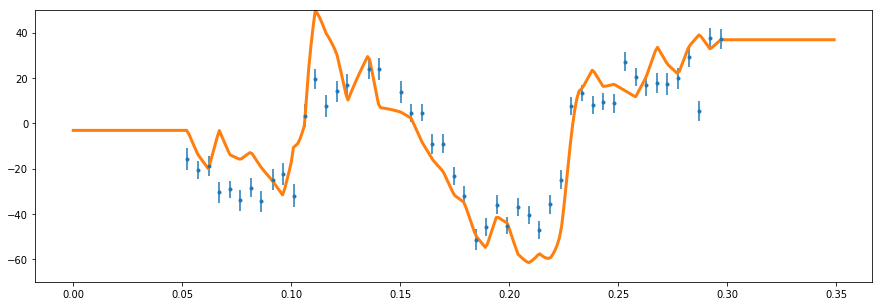

In [28]:
inputs = np.array([19300, 0.0688, -0.09, 20.79, 0.5, 0.40, 0.0, 20.0, 1.0, 0.166, -35000])

bnds = ((12000, 24000), (0.04, 0.09), (-1.0, 0.0), (15,25), (0,1),(0,1), (-30,90), (-20,50), (0.0, 20.0), (0.16, 0.175), (-100000, 0))
rmcurve(tuse, inputs)

tarr = np.arange(0.0, 0.35, 0.001)

plot_rmcurve(tarr, inputs)